# SED photometry and redshift demo

## Imports

We'll use 2 packages from `lsst.sims.photUtils` (documentation [here](https://github.com/lsst/sims_photUtils/tree/master/python/lsst/sims/photUtils)):

1. `BandpassDict`: This loads the LSST bandpasses into a dictionary of `Bandpass` methods that we can use to calculate photometry on `Sed` objects.

2. `Sed`: We can load SEDs from the LSST SED Library into `Sed` objects that we can use to redshift or with a `Bandpass` object easily calculate photometry.

We will also use `lsst.utils.getPackageDir` to get the location of the LSST Sims SED Library

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from lsst.sims.photUtils import BandpassDict, Sed
from lsst.utils import getPackageDir
%matplotlib inline

## Load an SED from the SED Library

When installing the `sims` packages of the LSST library the SED library is included in the `sims_sed_library` package. Here we'll find the location of the SED library and then load in an SED.

In [2]:
sed_library_loc = getPackageDir('sims_sed_library')
print(sed_library_loc)

/epyc/projects/sssc/lsst/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_sed_library/2017.01.24


Inside the library there are different types of SEDs in their own folders.

In [3]:
os.listdir(sed_library_loc)

['validation',
 'ups',
 'starSED',
 'ssmSED',
 'rrly_lc',
 'microlens',
 'mflare',
 'igm',
 'galaxySED',
 'flatSED',
 'eb_lc',
 'cepheid_lc',
 'agnSED',
 'README',
 'verify_eb_lc.sh',
 '.pwd']

We want to get the SEDs in the `galaxySED` folder.

In [4]:
galaxy_sed_folder = os.path.join(sed_library_loc, 'galaxySED')

In [5]:
sed_names = os.listdir(galaxy_sed_folder)

Inside the `galaxySED` folder are a set of galaxy SED from the Bruzual and Charlot (2003) code. For more information here is the `README` from the file located in the `README` folder of `sims_sed_library`.

In [6]:
% less /epyc/projects/sssc/lsst/stack/miniconda3-4.3.21-10a4fa6/Linux64/sims_sed_library/2017.01.24/README/galaxySED/README.txt

April 2015

The galaxySED folder contains models for galaxy bulges and disks.  SEDs in the
galaxySED folder come from the Bruzual and Charlot models with Chabrier (2003)
IMF and are calculated based upon 4 different star formation histories:

- Burst: an extended period of time during which star formation occurs and then
stops afterwards.

- Constant: Star formation at a constant rate throughout the galaxy's lifetime

- Exp: Exponentially declining star formation with an e-folding time of 1Gyr

- Instant: One single, instantaneous burst of star formation

With each of these star formation histories the ages of the galaxies come in 40
different age steps between 1.585 Myr and 12.5 Gyr.  Furthermore ate each age
tehy are available at 6 different metallicities which use the Padova 1994
isochrones from Z=0.0001 - 0.05 where solar Z is set at Z = 0.02.


Let's load the first one as an `SED` object.

In [7]:
test_sed = Sed()

In [8]:
test_sed.readSED_flambda('%s/%s' % (galaxy_sed_folder, sed_names[0]))

`test_sed` now has a `wavelen` property with the wavelengths in nm from the file and `flambda` which is a scaled flux as a function of the wavelength. We can use this to plot the SED.

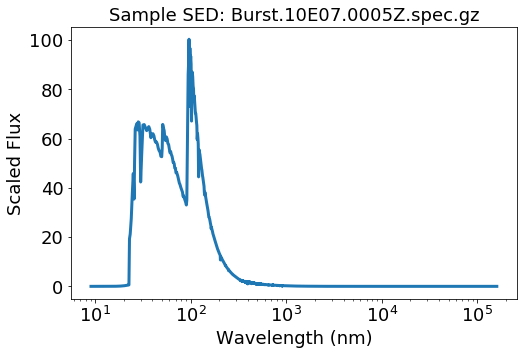

In [9]:
fig = plt.figure(figsize=(8,5))
plt.plot(test_sed.wavelen, test_sed.flambda, lw=3)
plt.xscale('log')
plt.xlabel('Wavelength (nm)', size=18)
plt.ylabel('Scaled Flux', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Sample SED: %s' % sed_names[0], size=18)

## Load LSST Bandpasses

Now we will load in the LSST bandpasses with a `bandpassDict` object. We use `loadTotalBandpassesFromFiles` which loads the complete LSST bandpasses including atmosphere and hardware components.

In [10]:
lsst_bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles()

`lsst_bandpass_dict` now has a set of `Bandpass` objects with keys that are the strings of the LSST bandpass names: u, g, r, i, z, or y

In [11]:
lsst_bandpass_dict.keys()

['u', 'g', 'r', 'i', 'z', 'y']

Each one of the `Bandpass` objects has a set of wavelengths and transmission curves that we can access. Here we get this information and plot the complete set of bandpasses.

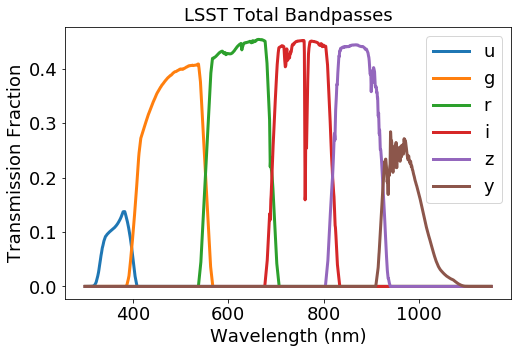

In [12]:
fig = plt.figure(figsize=(8,5))
for band_name in lsst_bandpass_dict.keys():
    plt.plot(lsst_bandpass_dict[band_name].wavelen, lsst_bandpass_dict[band_name].sb, lw=3, label=band_name)
plt.xlabel('Wavelength (nm)', size=18)
plt.ylabel('Transmission Fraction', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.legend(fontsize=18)
plt.title('LSST Total Bandpasses', size=18)

## Manipulate the SED

There are two useful manipulations we have tools to do in the `Sed` object.

* Redshift the SED.

  We can redshift the SED to a desired redshift and include cosmological dimming using `redshiftSED`.

In [13]:
target_redshift = 3.0
test_sed.redshiftSED(target_redshift)

* Normalize the SED to a specific magnitude:

  We can normalize the SED to a specific flux in a specific band. First we calculate what constant we need to normalize the SED with `calcFluxNorm` and then we do the normalization with `multiplyFluxNorm`. For this let's normalize to `r=22.5`.

In [14]:
target_mag = 22.5
target_band = lsst_bandpass_dict['r']
flux_norm = test_sed.calcFluxNorm(target_mag, target_band)
test_sed.multiplyFluxNorm(flux_norm)

**Note that both of these change `test_sed` as we go so the order will matter.** 

If you normalize the flux to `r=22.5` and then redshift the SED the magnitude will no longer be normalized to `r=22.5`.

## Calculate photometry for an SED

Now we take the SED and the Bandpasses and use them together to calculate photometry. `BandpassDict` has `fluxListForSed`, `fluxDictForSed`, `magListForSed`, and `magDictForSed` depending on how one wants the photometry returned.

First, let's calculate magnitudes and keep it as dictionary so we choose `magDictForSed`.

In [15]:
sed_mags_dict = lsst_bandpass_dict.magDictForSed(test_sed)

In [16]:
sed_mags_dict

OrderedDict([('u', 22.848772910628092),
             ('g', 22.285408225721905),
             ('r', 22.499966170090886),
             ('i', 22.712368341507741),
             ('z', 22.879152559559607),
             ('y', 23.016250838246449)])

Now let's calculate fluxes and plot them to get a rough spectrum.

In [17]:
sed_fluxes = lsst_bandpass_dict.fluxListForSed(test_sed)

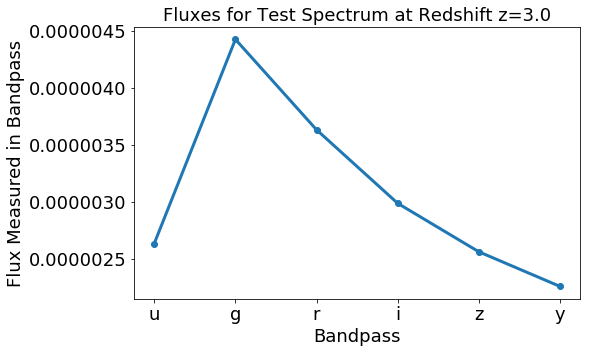

In [18]:
fig = plt.figure(figsize=(8,5))
plt.plot(np.arange(6), sed_fluxes, lw=3, marker='o')
plt.xticks(np.arange(6), lsst_bandpass_dict.keys(), size=18)
plt.yticks(size=18)
plt.xlabel('Bandpass', size=18)
plt.ylabel('Flux Measured in Bandpass', size=18)
plt.title('Fluxes for Test Spectrum at Redshift z=3.0', size=18)